In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw

from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.io
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size


from dateutil        import parser
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('paper')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.style.use('seaborn')


In [245]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [6]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]


y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))




file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]



lon_gsw = np.mean(lon)
lat_gsw = np.mean(lat)

bathy_file = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')
Z = bathy_file.variables['Bathymetry'][180:350, 480:650]

In [ ]:
path_of_file = '/data/ssahu/Falkor_2013/mvp/'

survey_file_A = path_of_file + 'surveyA.mat'
survey_file_B = path_of_file + 'surveyB.mat'
survey_file_D = path_of_file + 'surveyD.mat'
survey_file_E = path_of_file + 'surveyE.mat'
survey_file_G = path_of_file + 'surveyG.mat'

survey_file = [survey_file_A, survey_file_B, survey_file_D, survey_file_E, survey_file_G]

In [230]:
file = survey_file_E



mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [231]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])
        
q = np.empty_like(lon_survey)
p = np.empty_like(q)

In [232]:
for i in np.arange(lat_survey.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
q = q.astype(int)
p = p.astype(int)

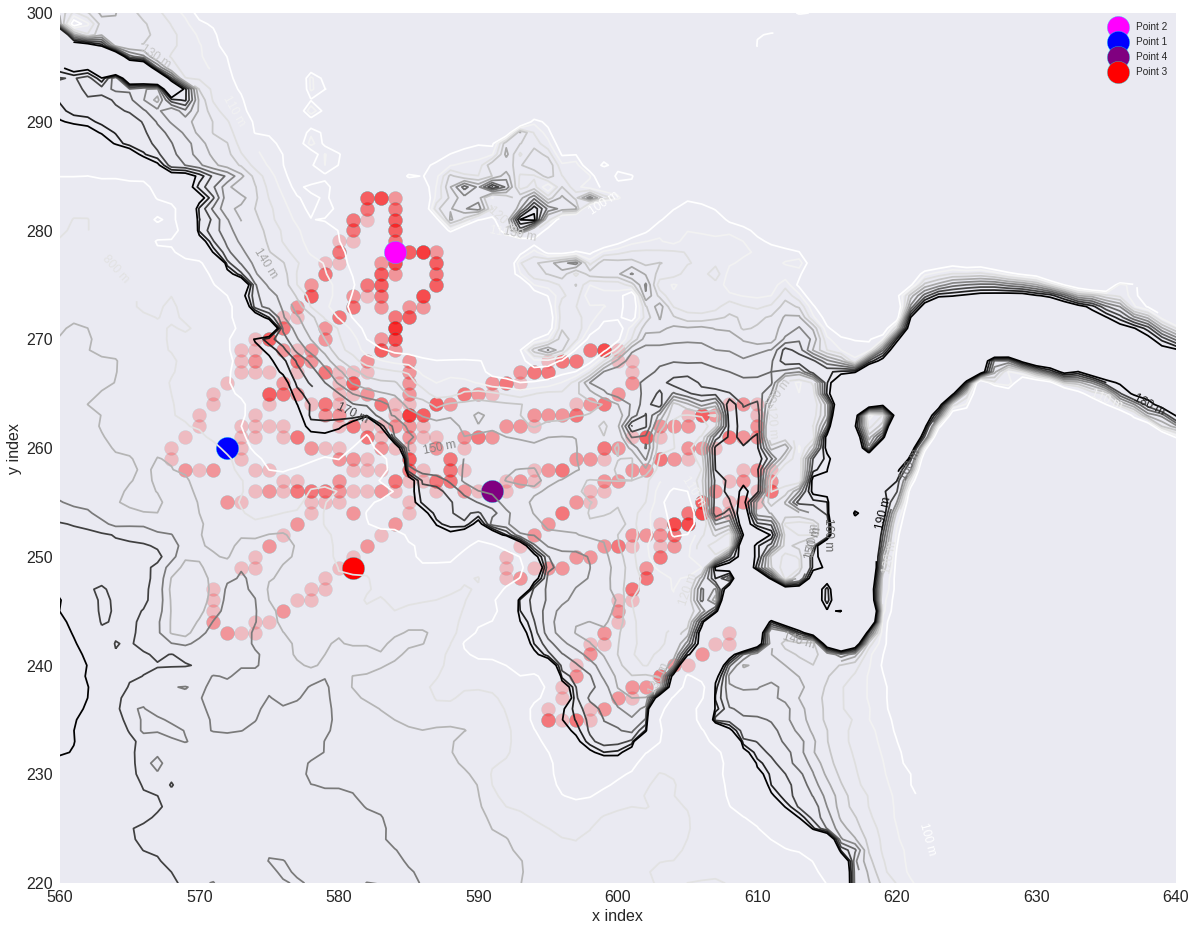

In [191]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.2, edgecolor= 'cyan' )


#First Attempt to select 2 points

ax.scatter(x_wcvi_slice[np.int(p[500])], y_wcvi_slice[np.int(q[500])], c = 'magenta', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 2' )

ax.scatter(x_wcvi_slice[np.int(p[420])], y_wcvi_slice[np.int(q[420])], c = 'blue', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 1' )    

ax.scatter(x_wcvi_slice[np.int(p[220])], y_wcvi_slice[np.int(q[220])], c = 'purple', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 4' )    

ax.scatter(x_wcvi_slice[np.int(p[688])], y_wcvi_slice[np.int(q[688])], c = 'red', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 3' ) 

ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.legend(loc = 'best')


In [192]:

np.where((y_wcvi_slice[q[:]]>240) & (y_wcvi_slice[q[:]]<250) & (x_wcvi_slice[p[:]]>570) & (x_wcvi_slice[p[:]]<590))

(array([667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679,
        680, 681, 682, 683, 684, 685, 686, 687, 688]),)

In [233]:
i1 = 420
i2 = 500

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [234]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 1 and 2 (Upstream of Barkley Canyon)


(-0.003, 0.003)

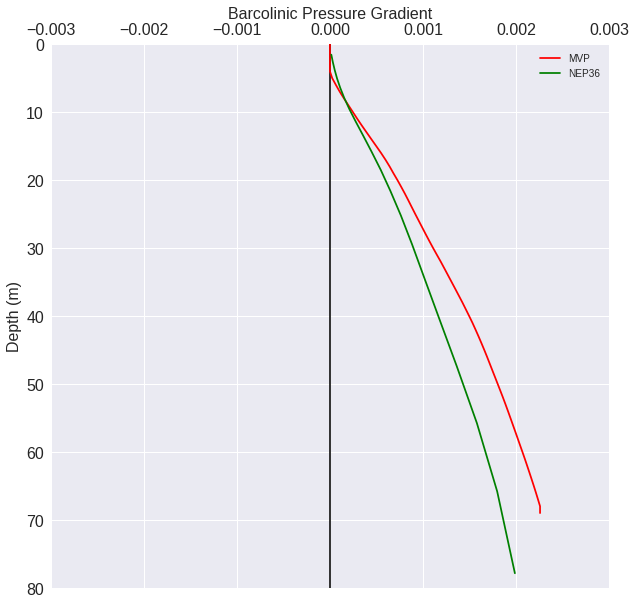

In [235]:
print("Between points 1 and 2 (Upstream of Barkley Canyon)")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,80)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.003,0.003)

In [236]:
i1 = 688
i2 = 220

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [237]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 3 and 4 (Downstream of Barkley Canyon)


(-0.0035, 0.0035)

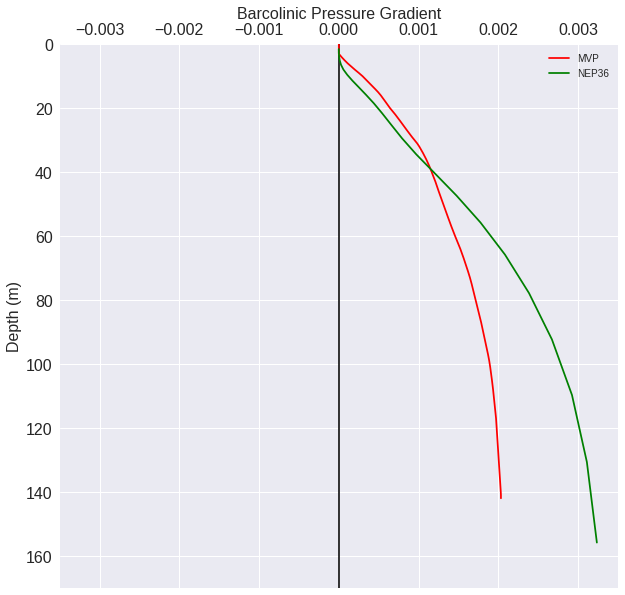

In [238]:
print("Between points 3 and 4 (Downstream of Barkley Canyon)")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)

In [239]:
file = survey_file_D



mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [240]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])
        
q = np.empty_like(lon_survey)
p = np.empty_like(q)

In [241]:
for i in np.arange(lat_survey.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
    
q = q.astype(int)
p = p.astype(int)

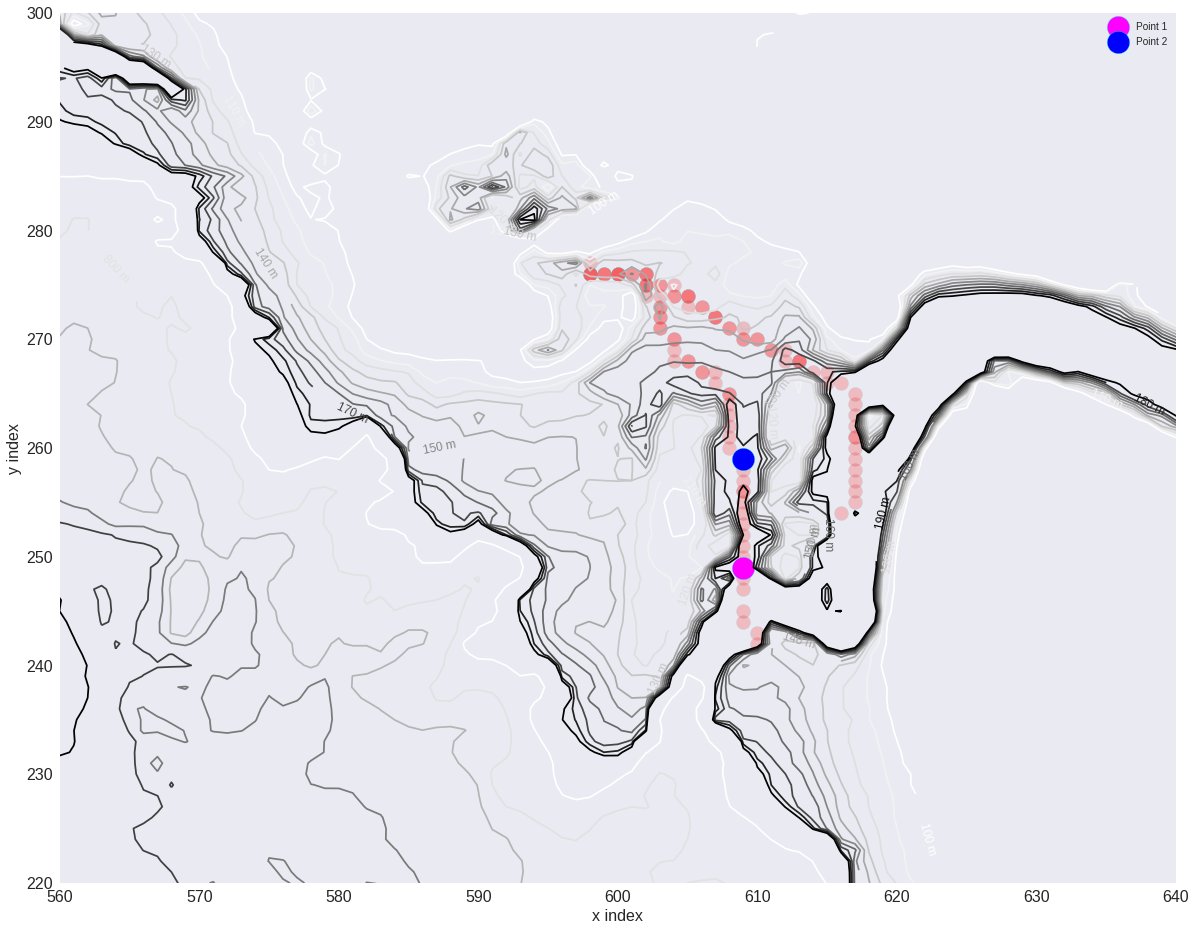

In [226]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.2, edgecolor= 'cyan' )


#First Attempt to select 2 points

ax.scatter(x_wcvi_slice[np.int(p[101])], y_wcvi_slice[np.int(q[101])], c = 'magenta', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 1' )

ax.scatter(x_wcvi_slice[np.int(p[90])], y_wcvi_slice[np.int(q[90])], c = 'blue', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 2' )    

# ax.scatter(x_wcvi_slice[np.int(p[220])], y_wcvi_slice[np.int(q[220])], c = 'purple', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 4' )    

# ax.scatter(x_wcvi_slice[np.int(p[688])], y_wcvi_slice[np.int(q[688])], c = 'red', cmap = cmap, s=500, alpha=1, edgecolor= 'cyan', label = 'Point 3' ) 

ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.legend(loc = 'best')


In [242]:
i1 = 101
i2 = 90

pden_point_1 = pden_survey[:,i1]
pden_point_2 = pden_survey[:,i2]

lat_point_1 = lat_survey[i1]
lat_point_2 = lat_survey[i2]

lon_point_1 = lon_survey[i1]
lon_point_2 = lon_survey[i2]

diff_rho = pden_point_2 - pden_point_1

dist = 1000*geo_tools.haversine(lon_point_1, lat_point_1, lon_point_2, lat_point_2)

drho = np.empty_like(diff_rho)

drho[:] = (diff_rho[:]/dist)
       
drho = np.nancumsum(drho)

In [243]:
if file == survey_file_E:
    t = 119
    
if file == survey_file_D:
    t = 118

q = q.astype(int)
p = p.astype(int)
    
pden_model_point_1 = rho[t,:,q[i1],p[i1]]
pden_model_point_2 = rho[t,:,q[i2],p[i2]]

pden_model_point_2[pden_model_point_2<1000] = 'Nan'

lat_model_point_1 = lat[q[i1],p[i1]]
lat_model_point_2 = lat[q[i2],p[i2]]

lon_model_point_1 = lon[q[i1],p[i1]]
lon_model_point_2 = lon[q[i2],p[i2]]

diff_rho_model = pden_model_point_2 - pden_model_point_1

dist_model = 1000*geo_tools.haversine(lon_model_point_1, lat_model_point_1, lon_model_point_2, lat_model_point_2)

zdiff = np.diff(zlevels,axis=0)

drho_model = np.empty_like(zdiff)

drho_model[:] = (diff_rho_model[1:]/dist)*zdiff[:]
       
drho_model = np.cumsum(drho_model)


Between points 1 and 2 (Through the Tully Canyon)


(-0.0035, 0.0035)

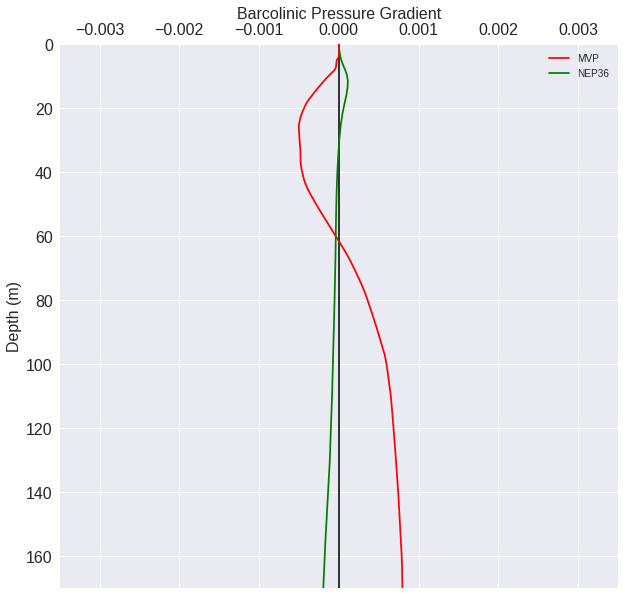

In [244]:
print("Between points 1 and 2 (Through the Tully Canyon)")

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))

zmax_level_mvp = pden_point_2[~np.isnan(pden_point_2)].shape



ax2.plot(drho[:zmax_level_mvp[0]+5] , depths_survey[:zmax_level_mvp[0]+5],  c = 'red',  label = 'MVP')
  
ax2.plot(drho_model[:] , zlevels[1:], c = 'green', label = 'NEP36')

ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,170)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Barcolinic Pressure Gradient', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.vlines(x = 0, ymin=ax2.get_ylim(), ymax = 0)
ax2.legend(loc= 'best')
ax2.set_xlim(-0.0035,0.0035)